<h1 align="left">Multi-investment Attribution: Distinguish the Effects of Multiple Outreach Efforts</h1>

<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Attribution.png" width="400">

A software company would like to know whether its multiple outreach efforts to their business customers are successful in boosting sales. They would also like to learn how to better target different incentives to different customers. In other words, they would like to learn the **treatment effect** of each investment on customers' total expenditure on the company’s products: particularly the **heterogeneous treatment effect**. 

In an ideal world, the company would run experiments where each customer would receive a random assortment of investments. However, this approach can be logistically prohibitive or strategically unsound: the company might not have the resources to design such experiments or they might not want to risk major revenue losses by randomizing their incentives to top customers.

In this notebook, we show how tools from the [Causica](https://github.com/microsoft/causica), library can use historical investment data to learn the effects of multiple investments.

For this exercise, we create simulated data that recreates some key characteristics of real data from a software company facing this type of decision. Simulating data protects the company’s privacy. Because we create the data, we are also in the unusual position of knowing the true causal graph and true effects of each investments, so we can compare the results of our estimation to this ground truth.

In the next section, we introduce this simulated data. We then discover the causal graph, the relationship between each variable in the simulated data. With this generated graph, we use estimate the personalized treatment effects for each customer. 

## Environment Setup
It might be necessary to install `graphviz` and `pygraphviz` for improved visualisations of the graphs.

For Ubuntu with poetry, run
```
sudo apt-get install graphviz libgraphviz-dev
```

In [1]:
import os
from operator import itemgetter
import warnings

import fsspec
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch


from pytorch_lightning.callbacks import TQDMProgressBar
from tensordict import TensorDict

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, Variable
from causica.distributions import ContinuousNoiseDist
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
from causica.lightning.modules.deci_module import DECIModule
from causica.sem.sem_distribution import SEMDistributionModule
from causica.sem.structural_equation_model import ite
from causica.training.auglag import AugLagLRConfig

warnings.filterwarnings("ignore")
test_run = bool(os.environ.get("TEST_RUN", False))  # used by testing to run the notebook as a script

# Data

The simulated dataset contains 10,000 customers. 

We create one outcome of interest:

Feature Name | Type | Details 
:--- |:--- |:--- 
**Revenue** | continuous | \$ Annual revenue from customer given by the amount of software purchased

We consider three possible treatments, the interventions whose impact we wish to measure:

Feature Name | Type | Details 
:--- |:--- |:--- 
**Tech Support** | binary | whether the customer received tech support during the year
**Discount** | binary | whether the customer was given a discount during the year
**New Strategy** | binary | whether the customer was targeted for a new engagement strategy with different outreach behaviors

Finally, we consider a variety of additional customer characteristics that may affect revenue. Including these types of features is crucial for causal analysis in order to map the full causal graph and separate the true effects of treatments on outcomes from other correlation generated by other influences. 

Feature Name | Type | Details 
:--- |:--- |:--- 
**Global Flag** | binary | whether the customer has global offices
**Major Flag** | binary | whether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or SMB - Small Medium Business)
**SMC Flag** | binary | whether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)
**Commercial Flag** | binary | whether the customer's business is commercial (as opposed to public secor)
**Planning Summit** | binary | whether a sales team member held an outreach event with the customer during the year
**New Product Adoption** | binary | whether the customer signed a contract for any new products during the year
**IT Spend** | continuous | \$ spent on IT-related purchases 
**Employee Count** | continuous | number of employees
**PC Count** | continuous | number of PCs used by the customer
**Size** | continuous | customer's total revenue in the previous calendar year

In simulating the data, we maintain some key characteristics of the data from the real company example, including some correlation patterns between features and some potentially difficult data characteristics, such as large outliers.

#### Import the Simulated Data

In [2]:
root_path = CAUSICA_DATASETS_PATH + "causal_ai_suite"
df = pd.read_csv(root_path + "/multi_attribution_data_20220819.csv")

# Load metadata telling us the data type of each column
variables_path = root_path + "/multi_attribution_data_20220819_data_types.json"
with fsspec.open(variables_path, mode="r", encoding="utf-8") as f:
    variables_spec = json.load(f)["variables"]

data_module = BasicDECIDataModule(
    df.loc[:, "Global Flag":"Revenue"],  # remove ground truth from dataframe
    variables=[Variable.from_dict(d) for d in variables_spec],
    batch_size=128,
    normalize=True,
)
num_nodes = len(data_module.dataset_train.keys())

In [3]:
# Data sample
print("Data Shape:", df.shape)
df.head()

Data Shape: (10000, 20)


,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,New Engagement Strategy,New Product Adoption,Planning Summit,Revenue,Direct Treatment Effect: Tech Support,Total Treatment Effect: Tech Support,Direct Treatment Effect: Discount,Total Treatment Effect: Discount,Direct Treatment Effect: New Engagement Strategy,Total Treatment Effect: New Engagement Strategy
0,0,0,1,1,72490,27,25,220417,1,0,0,1,0,39691.32,9408.34,10332.57,11020.85,11020.85,0,0
1,0,0,1,0,5985,19,12,12510,1,0,1,1,1,14492.54,5250.20,6174.43,625.50,625.50,0,0
2,0,0,1,0,34399,82,55,123530,0,0,0,0,0,16215.76,7470.60,8394.83,6176.50,6176.50,0,0
3,0,1,1,1,29705,103,58,79297,0,1,1,1,1,25426.04,6585.94,7510.17,3964.85,3964.85,0,0
4,0,0,1,1,13498,60,26,25472,1,0,1,1,1,21005.51,5509.44,6433.67,1273.60,1273.60,0,0


Import the Ground Truth Causal Effects

Unlike most real-world causal use cases, in this case we know the true causal relationships between treatments
and outcome because we have simulated the data.

We also extract those effects, created during data generation, to check our later causal effect estimates.
For now, we calculate the ground truth average and individual treatment effects (ATEs and ITEs).

In [4]:
outcome = "Revenue"
treatment_columns = ["Tech Support", "Discount", "New Engagement Strategy"]

# extract ground truth effects
ground_truth_effects = df.loc[:, "Direct Treatment Effect: Tech Support":]

ground_truth_ites = {
    treatment: ground_truth_effects[f"Total Treatment Effect: {treatment}"] for treatment in treatment_columns
}

ground_truth_ates = {key: val.mean(axis=0) for key, val in ground_truth_ites.items()}

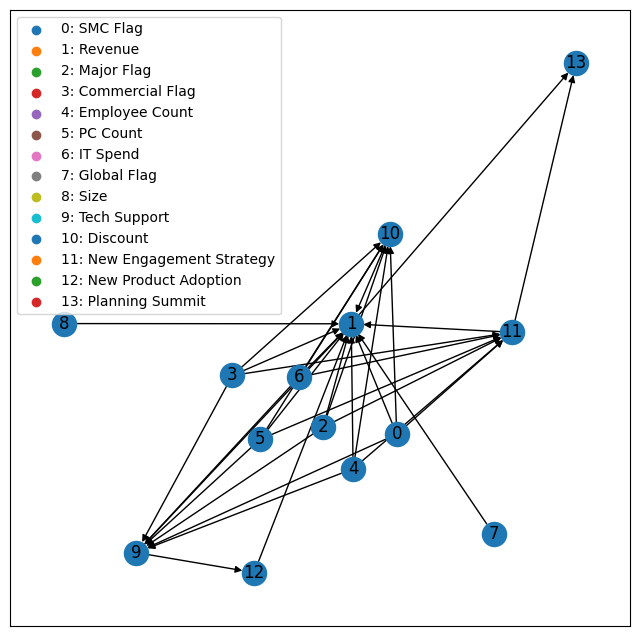

In [5]:
adjacency_path = root_path + "/true_graph_gml_string.txt"
with fsspec.open(adjacency_path, mode="r", encoding="utf-8") as f:
    true_adj = nx.parse_gml(f.read())

fig, axis = plt.subplots(1, 1, figsize=(8, 8))
labels = {node: i for i, node in enumerate(true_adj.nodes)}

try:
    layout = nx.nx_agraph.graphviz_layout(true_adj, prog="dot")
except (ModuleNotFoundError, ImportError):
    layout = nx.layout.spring_layout(true_adj)

for node, i in labels.items():
    axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
axis.legend()
nx.draw_networkx(true_adj, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis)

# Discover the Causal Graph

### [Optional] Adding domain-specific graph constraints
To improve the quality of the learned graph, it is possible to place constraints on the graph that DECI learns. The constraints come in two flavours:
 - *negative constraints* mean a certain edge cannot exist in the graph,
 - *positive constraints* mean a certain edge must exist in the graph.

In [6]:
# The constraint matrix has the same shape as the adjacency matrix
# A `nan` value means no constraint
# A 0 value means a negative constraint
# A 1 value means a positive constraint
node_name_to_idx = {key: i for i, key in enumerate(data_module.dataset_train.keys())}
constraint_matrix = np.full((num_nodes, num_nodes), np.nan, dtype=np.float32)

First, we introduce the constraint that Revenue cannot be the cause of any other node, except possibly Planning Summit.

In [7]:
revenue_idx = node_name_to_idx["Revenue"]
planning_summit_idx = node_name_to_idx["Planning Summit"]
constraint_matrix[revenue_idx, :] = 0.0
constraint_matrix[revenue_idx, planning_summit_idx] = np.nan

Second, we say that certain basic attributes of companies cannot be changed by other variables (at least on the time scale we are considering). The attributes we constraint to have no parents are: Commerical Flag, Major Flag, SMC Flag, PC Count, Employee Count, Global Flag, Size.

In [8]:
non_child_nodes = [
    "Commercial Flag",
    "Major Flag",
    "SMC Flag",
    "PC Count",
    "Employee Count",
    "Global Flag",
    "Size",
]
non_child_idxs = itemgetter(*non_child_nodes)(node_name_to_idx)
constraint_matrix[:, non_child_idxs] = 0.0

Finally, we make a constraint that says that different engagements do not directly cause one another. For example, giving Tech Support to a company is not a valid reason to give / not give them a Discount.

In [9]:
engagement_nodes = ["Tech Support", "Discount", "New Engagement Strategy"]
engagement_idxs = itemgetter(*engagement_nodes)(node_name_to_idx)
for i in engagement_idxs:
    constraint_matrix[engagement_idxs, i] = 0.0

### Creating and training DECI model

The following snippets step through the process of:
 - configuring and creating a DECI model
 - training a model with graph constraints

#### DECI configuration

The DECI model has a number of hyperparameters, but attention need not be paid to all of them. Here we highlight key hyperparameters that might be changed to improve performance:
 - `noise_dist` is the type of DECI model that is trained with. It should be either Gaussian or Spline. Use a Spline for highly non-Gaussian data, or to fit a better density model of the observational data.
 
Other hyperparameters are less frequently changed.

In [10]:
pl.seed_everything(seed=1)  # set the random seed

lightning_module = DECIModule(
    noise_dist=ContinuousNoiseDist.GAUSSIAN,
    prior_sparsity_lambda=43.0,
    init_rho=30.0,
    init_alpha=0.20,
    auglag_config=AugLagLRConfig(
        max_inner_steps=3400,
        max_outer_steps=8,
        lr_init_dict={
            "icgnn": 0.00076,
            "vardist": 0.0098,
            "functional_relationships": 3e-4,
            "noise_dist": 0.0070,
        },
    ),
)

lightning_module.constraint_matrix = torch.tensor(constraint_matrix)

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=2000,
    fast_dev_run=test_run,
    callbacks=[TQDMProgressBar(refresh_rate=19)],
    enable_checkpointing=False,
)

Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(lightning_module, datamodule=data_module)

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /workspaces/causica/pkg/causica/examples/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 20.1 K
------------------------------------------------------
19.9 K    Trainable params
196       Non-trainable params
20.1 K    Total params
0.081     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Updating alpha to: 71.24188232421875
Updating alpha to: 106.83052062988281
Updating rho, dag penalty prev:  1.1862878799
Updating alpha to: 534.152587890625
Updating rho, dag penalty prev:  0.0000000000
Updating alpha to: 2670.762939453125
Updating alpha to: 13353.814453125
Updating alpha to: 66769.0703125


### Saving and Loading a DECI model

In [12]:
torch.save(lightning_module.sem_module, "deci.pt")

In [13]:
sem_module: SEMDistributionModule = torch.load("deci.pt")

# create a structural equation model using the most likely graph
sem = sem_module().mode

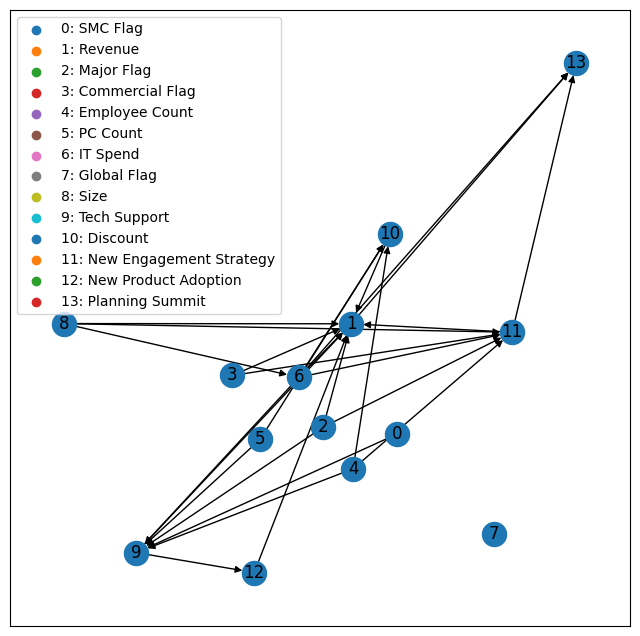

In [14]:
graph = nx.from_numpy_array(sem.graph.cpu().numpy(), create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, dict(enumerate(data_module.dataset_train.keys())))

fig, axis = plt.subplots(1, 1, figsize=(8, 8))

for node, i in labels.items():
    axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
axis.legend()

nx.draw_networkx(graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis)

### Concluding graph discovery
The DECI model from Causica offers us a way to discover a causal graph from observational data. The learned graph can be iteratively refined by adding new graph constraints and retraining DECI to obtain a more realistic graph. 

# Treatment effect estimation

The causal graph identifies the likely paths of connection between features. This next step will quantify the strength of those relationships between treatment and outcomes. Our tools estimate both the average treatment effect across all customers (ATE) and how these treatment effects vary across customer features. If we are confident that we have included every feature that affects treatment intensity, we can also interpret these estimates as individual treatment effects (ITE), or the effect of treating a particular customer.

## Average Treatment Effect (ATE)
We can estimate the average treatment and estimate the error using samples from the intervened SEM

In [15]:
revenue_estimated_ate = {}
num_samples = 10 if test_run else 20000
sample_shape = torch.Size([num_samples])
normalizer = data_module.normalizer

for treatment in treatment_columns:
    intervention_a = TensorDict({treatment: torch.tensor([1.0])}, batch_size=tuple())
    intervention_b = TensorDict({treatment: torch.tensor([0.0])}, batch_size=tuple())

    rev_a_samples = normalizer.inv(sem.do(interventions=intervention_a).sample(sample_shape))[outcome]
    rev_b_samples = normalizer.inv(sem.do(interventions=intervention_b).sample(sample_shape))[outcome]

    ate_mean = rev_a_samples.mean(0) - rev_b_samples.mean(0)
    ate_std = np.sqrt((rev_a_samples.var(0) + rev_b_samples.var(0)) / num_samples)

    revenue_estimated_ate[treatment] = (
        ate_mean.cpu().numpy()[0],
        ate_std.cpu().numpy()[0],
    )
revenue_estimated_ate

{'Tech Support': (8176.4062, 153.94827),
 'Discount': (5063.41, 151.71974),
 'New Engagement Strategy': (182.05078, 161.37265)}

These graphs compare the average total treatment effects of Causica with the ground truth.

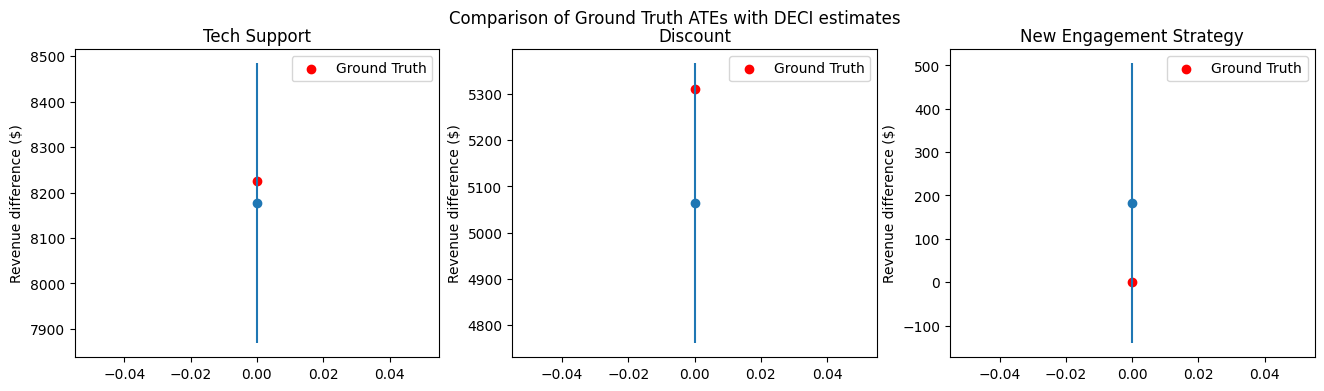

In [16]:
fig, axes = plt.subplots(1, len(ground_truth_ates), figsize=(16, 4))
fig.suptitle("Comparison of Ground Truth ATEs with DECI estimates")
for ax, treatment in zip(axes, revenue_estimated_ate.keys()):
    ax.errorbar([0], [revenue_estimated_ate[treatment][0]], [2 * revenue_estimated_ate[treatment][1]], fmt="o")
    ax.scatter([0], [ground_truth_ates[treatment]], color="r", label="Ground Truth")
    ax.legend()
    ax.set_title(treatment)
    ax.set_ylabel("Revenue difference ($)")

## Individual treatment effects (ITE)

Finally, Causica can estimate *individual* treatment effects: the difference between giving and not giving the engagement to a specific customer. Using the original data, we can examine what the difference in Revenue would be for each interaction if we had performed the intervention.

In [17]:
revenue_estimated_ite = {}

base_noise = sem.sample_to_noise(data_module.dataset_train)

for treatment in treatment_columns:
    do_sem = sem.do(interventions=TensorDict({treatment: torch.tensor([1.0])}, batch_size=tuple()))
    do_a_cfs = normalizer.inv(do_sem.noise_to_sample(base_noise))[outcome].cpu().detach().numpy()[:, 0]
    do_sem = sem.do(interventions=TensorDict({treatment: torch.tensor([0.0])}, batch_size=tuple()))
    do_b_cfs = normalizer.inv(do_sem.noise_to_sample(base_noise))[outcome].cpu().detach().numpy()[:, 0]
    revenue_estimated_ite[treatment] = do_a_cfs - do_b_cfs

revenue_estimated_ite

{'Tech Support': array([ 8218.861 ,  5665.8604,  9793.176 , ...,  7723.617 ,  5633.7676,
        11714.125 ], dtype=float32),
 'Discount': array([10727.676  , -1442.8438 ,  6223.4414 , ...,  6601.885  ,
          423.50586,  7198.4336 ], dtype=float32),
 'New Engagement Strategy': array([ 21.433594, -23.797852,  80.54297 , ..., -39.203125, -32.075195,
        -72.13281 ], dtype=float32)}

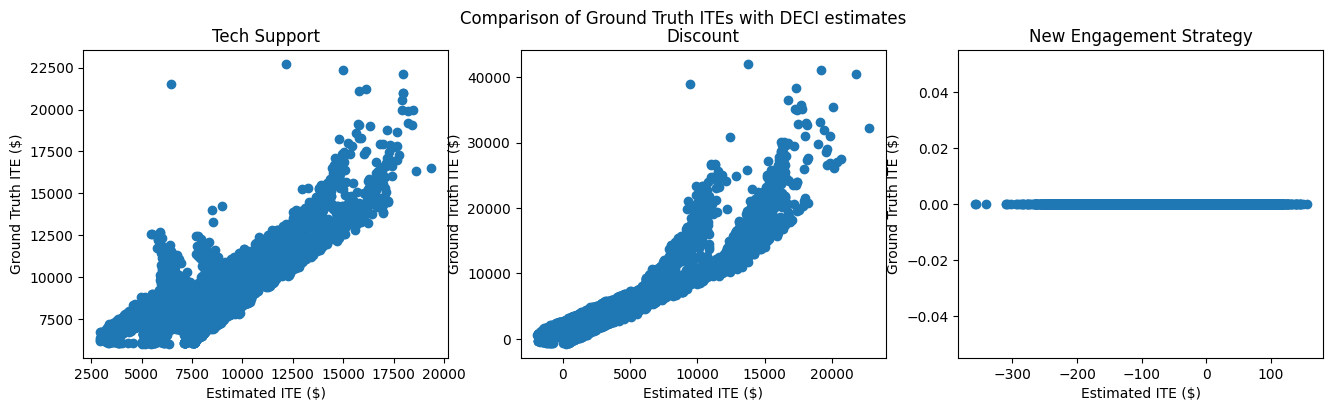

In [18]:
fig, axes = plt.subplots(1, len(ground_truth_ates), figsize=(16, 4))
fig.suptitle("Comparison of Ground Truth ITEs with DECI estimates")
for ax, treatment in zip(axes, revenue_estimated_ite.keys()):
    ax.scatter(revenue_estimated_ite[treatment], ground_truth_ites[treatment])
    ax.set_title(treatment)
    ax.set_xlabel("Estimated ITE ($)")
    ax.set_ylabel("Ground Truth ITE ($)")